<h1>Modeling and Prediction</h1>
On the West Nile Virus data set

In [80]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set_style('whitegrid')

In [98]:
#loading cleaned data
df = pd.read_pickle('./data/df_best.pkl')
X = df.drop('WnvPresent',axis=1)
y = df.WnvPresent

df_avg = pd.read_pickle('./data/df_avg.pkl')
X_avg = df_avg.drop('WnvPresent',axis=1)
y_avg = df_avg.WnvPresent

In [82]:
# mistakenly, thought that the train_test_split was done for me. It was not, the test set is for the kaggle competition
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)

In [83]:
max_bin = 20
force_bin = 3

def mono_bin(Y, X, n = max_bin):
    
    np.seterr(divide='ignore')
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = np.divide(d3.EVENT,d3.COUNT)
    d3["NON_EVENT_RATE"] = np.divide(d3.NONEVENT,d3.COUNT)
    d3["DIST_EVENT"] = np.divide(d3.EVENT,d3.sum().EVENT)
    d3["DIST_NON_EVENT"] = np.divide(d3.NONEVENT,d3.sum().NONEVENT)
    d3["WOE"] = np.log(np.divide(d3.DIST_EVENT,d3.DIST_NON_EVENT))
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*d3.WOE
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(pd.Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [84]:
final_iv, IV = data_vars(X, y)



In [99]:
final_iv_avg, IV_avg = data_vars(X_avg,y_avg)

In [102]:
features_avg = list(IV_avg[(IV_avg['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X_avg = df_avg[features_avg]

In [104]:
X_avg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AvgSpeed      10506 non-null  float64
 1   Depart        10506 non-null  float64
 2   FG            10506 non-null  float64
 3   Latitude      10506 non-null  float64
 4   Longitude     10506 non-null  float64
 5   PrecipTotal   10506 non-null  float64
 6   ResultSpeed   10506 non-null  float64
 7   Sunrise       10506 non-null  float64
 8   Sunset        10506 non-null  float64
 9   Tavg          10506 non-null  float64
 10  sunrise_diff  10506 non-null  float64
dtypes: float64(11)
memory usage: 984.9 KB


In [85]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X[features]

In [97]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10351 entries, 0 to 10350
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AvgSpeed 32.0 lag     10351 non-null  float64
 1   BR 48.0 lag           10351 non-null  float64
 2   DZ 59.0 lag           10351 non-null  float64
 3   Depart 3.0 lag        10351 non-null  float64
 4   HZ 10.0 lag           10351 non-null  float64
 5   Latitude              10351 non-null  float64
 6   Longitude             10351 non-null  float64
 7   PrecipTotal 59.0 lag  10351 non-null  float64
 8   RA 48.0 lag           10351 non-null  float64
 9   ResultSpeed 32.0 lag  10351 non-null  float64
 10  SeaLevel 32.0 lag     10351 non-null  float64
 11  StnPressure 32.0 lag  10351 non-null  float64
 12  Sunrise 2.0 ewm       10351 non-null  float64
 13  Sunset 5.0 lag        10351 non-null  float64
 14  Tavg 59.0 ewm         10351 non-null  float64
 15  spray_month        

In [94]:
def iterate_vif(df, vif_threshold=10, max_vif=11):
  count = 0
  while max_vif > vif_threshold:
    count += 1
    print("Iteration # "+str(count))
    vif = pd.DataFrame()
    vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    
    if np.round(vif['VIFactor'].max(),1) > vif_threshold:
      print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], np.round(vif['VIFactor'].max(),1)))
      df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
      max_vif = np.round(vif['VIFactor'].max(),1)
    else:
        print('Complete')
        return df, np.round(vif.sort_values('VIFactor'),1)


In [95]:
X1 = X2._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1
Removing SeaLevel 32.0 lag with VIF of 632560331.900000
Iteration # 2
Removing Longitude with VIF of 1014909.400000
Iteration # 3
Removing StnPressure 32.0 lag with VIF of 167531.000000
Iteration # 4
Removing Latitude with VIF of 44379.100000
Iteration # 5
Removing Sunset 5.0 lag with VIF of 4346.700000
Iteration # 6
Removing AvgSpeed 32.0 lag with VIF of 1367.200000
Iteration # 7
Removing Sunrise 2.0 ewm with VIF of 511.200000
Iteration # 8
Removing Tavg 59.0 ewm with VIF of 115.600000
Iteration # 9
Removing RA 48.0 lag with VIF of 100.800000
Iteration # 10
Removing BR 48.0 lag with VIF of 27.400000
Iteration # 11
Removing ResultSpeed 32.0 lag with VIF of 14.100000
Iteration # 12
Complete


In [96]:
final_vif

,VIFactor,features
4,1.1,spray_month
1,1.4,Depart 3.0 lag
5,1.9,sunset_diff 28.0 lag
2,2.0,HZ 10.0 lag
0,2.9,DZ 59.0 lag
3,4.9,PrecipTotal 59.0 lag


<h2>Random Forest Classifier</h2>
Random Forest Classifier is a great ensemble method which I will look into first with a Random Search CV. The driving metric for analysis is roc_auc. This data set is heavily class biased -- there are few west nile virus sightings compared to the observations as a whole. The area under the roc curve is relatively good at handling this sort of imbalance.

***Building Pipeline***

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from scipy.stats import truncnorm, uniform


In [5]:
pipe = make_pipeline( 
    StandardScaler(), 
    RandomForestClassifier()
)

In [6]:
pipe.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'randomforestclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_impurity_split', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

In [7]:
params = {'randomforestclassifier__n_estimators': np.arange(50,2000),
         'randomforestclassifier__max_depth' :  np.arange(2,20)}

rf_rand = RandomizedSearchCV(pipe,param_distributions=params,cv=5, n_jobs=-1, scoring = 'roc_auc',n_iter=10,
                            random_state = 42, verbose= 10)

In [8]:
rf_rand.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   48.5s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   51.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   51.4s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'randomforestclassifier__n_estimators': array([  50,   51,   52, ..., 1997, 1998, 1999])},
                   random_state=42, scoring='roc_auc', verbose=10)

***Looking at results from the random search***

In [9]:
rf_rand.best_params_

{'randomforestclassifier__n_estimators': 465,
 'randomforestclassifier__max_depth': 5}

In [10]:
rf_res = pd.DataFrame(rf_rand.cv_results_)


In [11]:
rf_res.sort_values('mean_test_score',axis=0, ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,3.903984,0.141170,0.178097,0.008327,465,5,"{'randomforestclassifier__n_estimators': 465, ...",0.873748,0.872081,0.881227,0.902998,0.843252,0.874661,0.019184,1
2,15.560370,0.294438,0.734438,0.078143,1584,7,"{'randomforestclassifier__n_estimators': 1584,...",0.870313,0.871995,0.884310,0.895392,0.844828,0.873367,0.016915,2
4,15.497140,0.237734,0.657902,0.034508,1300,10,"{'randomforestclassifier__n_estimators': 1300,...",0.859938,0.868130,0.878193,0.886494,0.842837,0.867119,0.015101,3
6,5.329918,0.107820,0.258977,0.014633,473,10,"{'randomforestclassifier__n_estimators': 473, ...",0.859429,0.866187,0.876526,0.887140,0.845867,0.867030,0.014149,4
0,2.685724,0.032817,0.118585,0.005838,245,10,"{'randomforestclassifier__n_estimators': 245, ...",0.860038,0.863068,0.877681,0.884713,0.843352,0.865770,0.014446,5
9,2.886940,0.152260,0.123136,0.013986,533,3,"{'randomforestclassifier__n_estimators': 533, ...",0.872787,0.855119,0.869342,0.899674,0.825922,0.864569,0.024106,6
5,7.076944,0.516579,0.291820,0.019430,562,13,"{'randomforestclassifier__n_estimators': 562, ...",0.849426,0.854761,0.868069,0.876937,0.834217,0.856682,0.014839,7
8,4.830910,0.185772,0.282621,0.037478,819,2,"{'randomforestclassifier__n_estimators': 819, ...",0.864649,0.841657,0.857808,0.893519,0.818089,0.855144,0.025000,8
1,5.254648,0.111899,0.310587,0.027266,910,2,"{'randomforestclassifier__n_estimators': 910, ...",0.863297,0.840743,0.856919,0.894327,0.817962,0.854650,0.025273,9
7,10.431660,0.122306,0.625291,0.021673,1735,2,"{'randomforestclassifier__n_estimators': 1735,...",0.863914,0.842241,0.858669,0.891734,0.815116,0.854335,0.025273,10


In [12]:
rf_rand.best_score_

0.874661076397337

In [13]:
from sklearn.metrics import roc_curve

def roc_plot(e,x,y):
    """e is estimator, x is data and y is true value"""

    #predicting from model
    y_pred = e.predict_proba(x)[:,1]

    #finding curve
    fpr, tpr, t = roc_curve(y, y_pred)
    sns.lineplot(x=fpr,y=tpr)
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('Compute Receiver Operating Characteristic Curve')
    return pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':t})

    


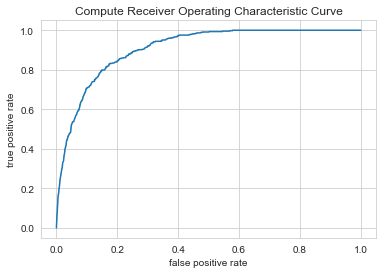

In [14]:
est = rf_rand.best_estimator_
c = roc_plot(est, X_train, y_train)

***Comparing to test set***

In [15]:
from sklearn.metrics import roc_auc_score


def test_comp(e):
    #predicting probability from test set
    y_pred = e.predict_proba(X_test)[:,1]
    
    
    r = np.round(roc_auc_score(y_test,y_pred),3)
    
    print('Evaluating the classifier on the test set, area under the roc curve is: ' +  
           '{}'.format(r))

test_comp(rf_rand.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.841


<h3>Random Forest first results</h3>

The classifier has decent performance. Let's see if with more parameters and a larger search I can improve the results even further.

In [16]:
params = {'randomforestclassifier__n_estimators': np.arange(50,2000),
         'randomforestclassifier__max_depth' :  np.arange(1,14)}

rf_rand_two = RandomizedSearchCV(pipe,param_distributions=params,cv=4, n_jobs=-1, scoring = 'roc_auc',n_iter=50,
                            random_state = 42, verbose = 10)
rf_rand_two.fit(X_train,y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
                                        'randomforestclassifier__n_estimators': array([  50,   51,   52, ..., 1997, 1998, 1999])},
                   random_state=42, scoring='roc_auc', verbose=10)

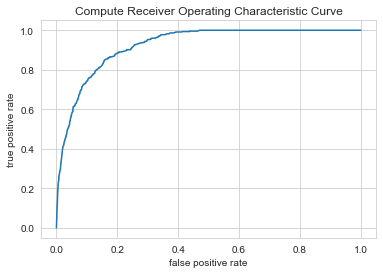

In [17]:
c = roc_plot(rf_rand_two.best_estimator_,X_train,y_train)


In [18]:
rf_rand_two.best_params_

{'randomforestclassifier__n_estimators': 927,
 'randomforestclassifier__max_depth': 6}

In [19]:
rf_rand_two.best_score_

0.8755481740777702

In [20]:
test_comp(rf_rand_two.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.845


In [21]:
rf_res = pd.DataFrame(rf_rand_two.cv_results_)
rf_res.sort_values('mean_test_score',axis=0, ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
46,8.211403,0.108180,0.485250,0.008161,927,6,"{'randomforestclassifier__n_estimators': 927, ...",0.869707,0.883493,0.898190,0.850802,0.875548,0.017480,1
6,13.957325,0.123932,0.864142,0.008131,1584,6,"{'randomforestclassifier__n_estimators': 1584,...",0.868567,0.883543,0.897830,0.851475,0.875354,0.017237,2
27,7.584947,0.057096,0.465669,0.009473,916,5,"{'randomforestclassifier__n_estimators': 916, ...",0.871356,0.881366,0.897693,0.850449,0.875216,0.017113,3
40,17.358102,0.103123,0.942488,0.006860,1694,6,"{'randomforestclassifier__n_estimators': 1694,...",0.869054,0.883183,0.896913,0.851087,0.875059,0.016988,4
49,4.937378,0.062450,0.177464,0.005023,553,6,"{'randomforestclassifier__n_estimators': 553, ...",0.868213,0.883486,0.897627,0.850711,0.875009,0.017464,5
13,16.109111,0.155420,0.837374,0.022944,1663,6,"{'randomforestclassifier__n_estimators': 1663,...",0.868204,0.882969,0.896836,0.851443,0.874863,0.016892,6
47,8.527889,0.089610,0.515632,0.010360,1042,5,"{'randomforestclassifier__n_estimators': 1042,...",0.869282,0.881446,0.897948,0.850604,0.874820,0.017291,7
43,9.367031,0.114106,0.577715,0.012166,1088,5,"{'randomforestclassifier__n_estimators': 1088,...",0.869749,0.881377,0.897401,0.850107,0.874658,0.017243,8
5,2.974204,0.085998,0.179309,0.005086,314,7,"{'randomforestclassifier__n_estimators': 314, ...",0.867367,0.882244,0.896523,0.852355,0.874622,0.016479,9
48,7.852758,0.038200,0.453042,0.045422,855,6,"{'randomforestclassifier__n_estimators': 855, ...",0.868769,0.882882,0.896074,0.849614,0.874335,0.017232,10


<h3>Random Forest second results</h3>

More iterations in the random search yeilded an almost non-existent improvement. I will explore other classifiers before doing a thorough grid search within a more confined range, which will take a good amount of time. 

<h3>Random Forest Conclusions</h3>

The Random Forest Classifier performs well out of the gate with an auc of 0.863 on the training set and 0.894 on the test set. The optimal max depth appears to be either 5 or 6 and the optimal number of estimators is likely between 750 - 1750

<h2>Logistic Regression</h2>


In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
pipe_lr = make_pipeline( 
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

params = {'logisticregression__C': np.logspace(-2,6)}

#starting with few iterations, and narrowing the ranges afterwards
lr = RandomizedSearchCV(pipe_lr,param_distributions=params,cv=5, n_jobs=-1, verbose =10, 
                                 scoring = 'roc_auc',n_iter=20,random_state = 42)


In [24]:
lr.fit(X,y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   28.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.7s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=1000))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'logisticregression__C': array([1.00000000e-02, 1.45634848e-02, 2.12095089e-02, 3.08884360e-02,
       4.49843267e-02, 6.55128557e-02, 9.54095476e-02, 1.38949549e-01,
       2.02358965e-0...
       3.72759372e+02, 5.42867544e+02, 7.90604321e+02, 1.15139540e+03,
       1.67683294e+03, 2.44205309e+03, 3.55648031e+03, 5.17947468e+03,
       7.54312006e+03, 1.09854114e+04, 1.59985872e+04, 2.32995181e+04,
       3.39322177e+04, 4.94171336e+04, 7.19685673e+04, 1.04811313e+05,
       1.52641797e+05, 2.22299648e+05, 3.23745754e+05, 4.71486636e+05,
       6.86648845e+05, 1.00000000e+06])},
                   random

In [25]:
lr.best_params_

{'logisticregression__C': 0.030888435964774818}

In [26]:
lr.best_score_

0.6718474443831586

<h3>ROC auc - Logistic Regression</h3>


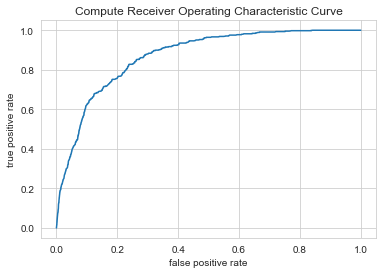

In [27]:
c = roc_plot(lr.best_estimator_,X_train,y_train)

<h3>Evaluating with test set</h3>

In [28]:
test_comp(lr.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.841


<h3>Logistic Regression Conclusions</h3>

The logistic regression results were considerably worse on the training set than random forest. But surprisingly close for the test set. I prefer the random forest classifier, and I expect that on a different test set, I would see different results. 

<h2>KNN </h2>

I don't expect KNN to give better results due to the high-dimensionality of the feature space. I expect PCA to be necessary, though I will try it without first. 

In [29]:
from sklearn.neighbors import KNeighborsClassifier

pipe_knn = make_pipeline( 
    StandardScaler(),
    KNeighborsClassifier(weights='distance')
)

params = {'kneighborsclassifier__n_neighbors': np.arange(1,200)}
    

#starting with few iterations, and narrowing the ranges afterwards
knn = RandomizedSearchCV(pipe_knn,param_distributions=params,cv=5, n_jobs=-1, verbose =10, 
                                 scoring = 'roc_auc',n_iter=200,random_state = 42)

knn.fit(X_train,y_train)

Fitting 5 folds for each of 199 candidates, totalling 995 fits


/Users/jon/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 199 is smaller than n_iter=200. Running 199 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('kneighborsclassifier',
                                              KNeighborsClassifier(weights='distance'))]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'kneighborsclassifier__n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,...
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 

In [30]:
knn.best_params_

{'kneighborsclassifier__n_neighbors': 154}

In [31]:
knn.best_score_

0.8349048760854393

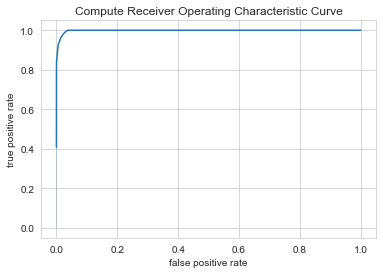

In [32]:
c = roc_plot(knn.best_estimator_,X_train,y_train)

In [33]:
test_comp(knn.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.798


Knn performed better than expected, with a max aoc of 0.827 for train and similar for test. Let's see if PCA improves

In [34]:
from sklearn.decomposition import PCA

pipe_knn = make_pipeline( 
    StandardScaler(),
    PCA(),
    KNeighborsClassifier(weights='distance')
)

params = {'pca__n_components' : np.arange(2,X.shape[1]),
          'kneighborsclassifier__n_neighbors': np.arange(50,250)}
    

#starting with few iterations, and narrowing the ranges afterwards
knn = RandomizedSearchCV(pipe_knn,param_distributions=params,cv=5, n_jobs=-1, verbose =10, 
                                 scoring = 'roc_auc',n_iter=200,random_state = 42)

knn.fit(X_train,y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('pca', PCA()),
                                             ('kneighborsclassifier',
                                              KNeighborsClassifier(weights='distance'))]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'kneighborsclassifier__n_neighbors': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  8...
       193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249

In [35]:
knn.best_params_

{'pca__n_components': 12, 'kneighborsclassifier__n_neighbors': 60}

In [36]:
knn.best_score_

0.8460860786211715

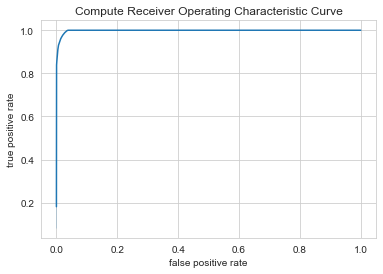

In [37]:
c = roc_plot(knn.best_estimator_,X_train,y_train)

<h3>Evaluating with test set</h3>

In [38]:
test_comp(knn.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.828


<h3>KNN Conclusions</h3>

PCA did not improve things by much, if at all. It's certainly not worth it to lose feature importances. 

<h2>SVC</h2>

SVC is supposedly good in high dimension data, and the set I have is relatively high dimension. 

In [39]:
from sklearn.svm import SVC

pipe_svc = make_pipeline( 
    StandardScaler(),
    SVC(probability=True)
)

params = {'svc__C': np.logspace(-5,5)}
    

#starting with few iterations, and narrowing the ranges afterwards
svc = RandomizedSearchCV(pipe_svc,param_distributions=params,cv=5, n_jobs=-1, verbose =10, 
                                 scoring = 'roc_auc',n_iter=10,random_state = 42)

svc.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  3.1min remaining:   41.0s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  4.9min remaining:   18.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.6min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svc', SVC(probability=True))]),
                   n_jobs=-1,
                   param_distributions={'svc__C': array([1.00000000e-05, 1.59985872e-05, 2.55954792e-05, 4.09491506e-05,
       6.55128557e-05, 1.04811313e-04, 1.67683294e-04, 2.68269580e-04,
       4.29193426e-04, 6.86648845e-04, 1.09854114e-03, 1.75751062e-03,
       2.811...
       5.17947468e+00, 8.28642773e+00, 1.32571137e+01, 2.12095089e+01,
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05])},
                   random_state=42, scoring='roc_auc', verbos

In [40]:
svc.best_params_

{'svc__C': 62505.51925273976}

In [41]:
svc.best_score_

0.8060485701413194

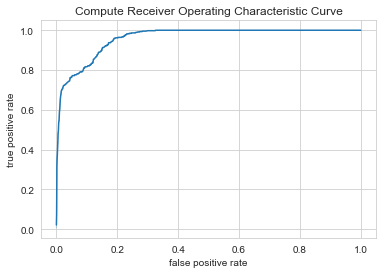

In [42]:
c = roc_plot(svc.best_estimator_,X_train,y_train)

<h3>Evaluating with test set</h3>

In [43]:
test_comp(svc.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.786


<h3>SVC Conclusions</h3>

SVC clearly performs worse

<h1>Choosing a classifier</h1>

Two models stand out as options to ultimately choose -- Random Forest and KNN. The random forest model has a feature importance attribute, which is a great piece of data, so I will choose it. 

In [46]:
from sklearn.model_selection import GridSearchCV

pipe_rf = make_pipeline( 
    StandardScaler(), 
    RandomForestClassifier()
)

params = {'randomforestclassifier__n_estimators': np.arange(750,2000,50),
          'randomforestclassifier__max_depth' :  np.arange(4,10)}

rf = GridSearchCV(pipe,param_grid=params,cv=5, n_jobs=-1, scoring = 'roc_auc',verbose=10)

rf.fit(X_train,y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': array([4, 5, 6, 7, 8, 9]),
                         'randomforestclassifier__n_estimators': array([ 750,  800,  850,  900,  950, 1000, 1050, 1100, 1150, 1200, 1250,
       1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800,
       1850, 1900, 1950])},
             scoring='roc_auc', verbose=10)

In [47]:
rf.best_params_

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__n_estimators': 800}

***Evaluating Performance***

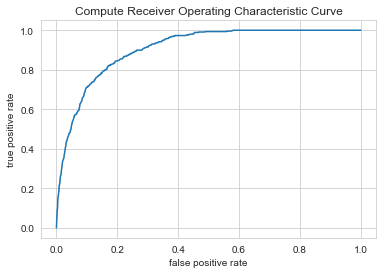

In [48]:
c = roc_plot(rf.best_estimator_,X_train,y_train)

In [49]:
test_comp(rf.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.841


***Looking at feature importance***

In [51]:
r = rf.best_estimator_
imp = r.steps[1][1].feature_importances_

<AxesSubplot:xlabel='importance', ylabel='feature'>

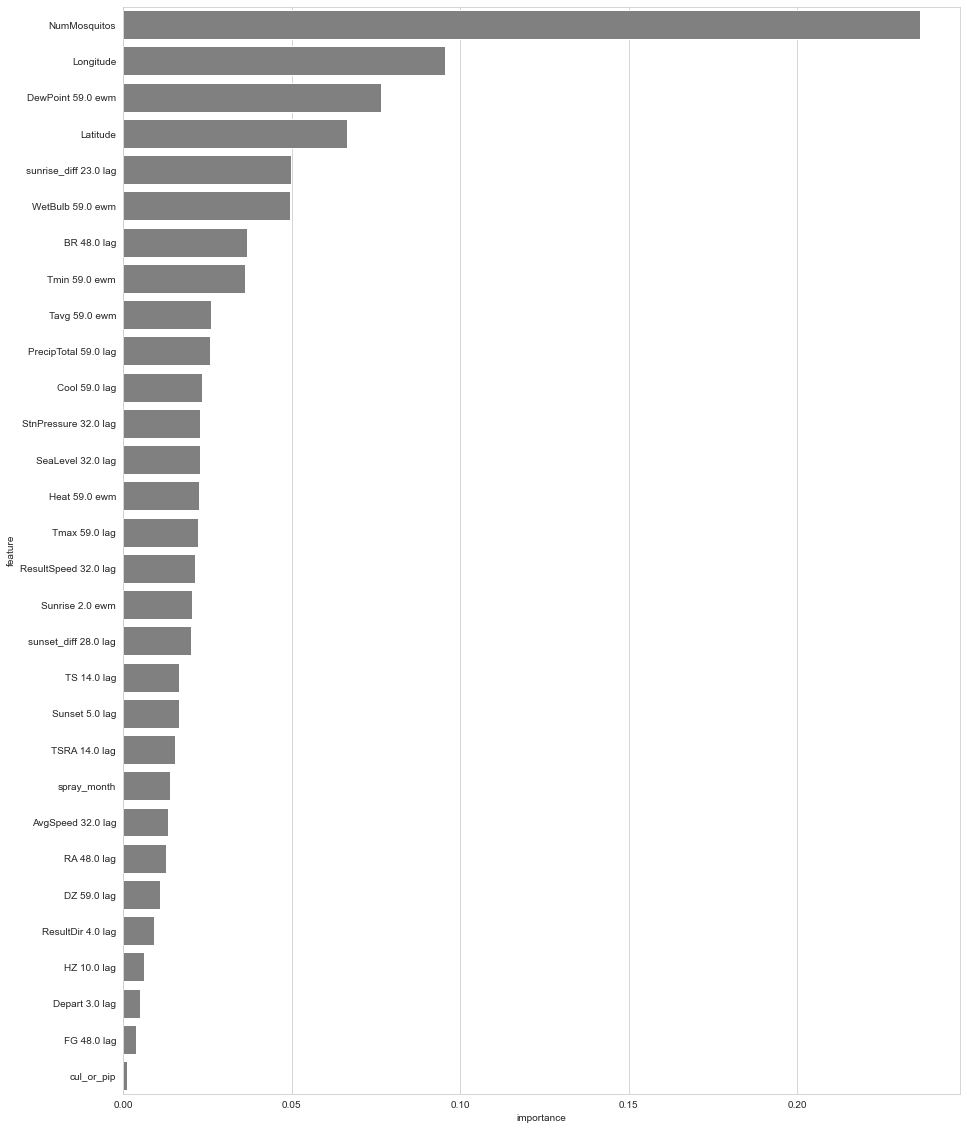

In [52]:
ax = plt.figure(figsize=(15,20))

i = pd.DataFrame({'feature':X_test.columns,'importance':imp}).sort_values('importance',ascending=False)

sns.barplot(data=i,y='feature',x='importance',orient='h',color='gray')

<h1>Conclusions</h1>
